# TFDS Python Interoperability with Swift

S5TF Team is actively developing a new `Datasets` library, however in the meantime we can take advantage of the excellent Python interoperability to load datasets from [TFDS](https://github.com/tensorflow/datasets/). Below is an example of how to do this with the MNIST dataset.

## Importing dependencies

In [0]:
import TensorFlow
import Python

let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
let tfds = Python.import("tensorflow_datasets")
let tf = Python.import("tensorflow")

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

Eager execution is required:

In [0]:
tf.compat.v1.enable_eager_execution()

## Load MNIST

In [0]:
let mnist = tfds.load(name: "mnist", split: "train", shuffle_files: true)

Inspect data:

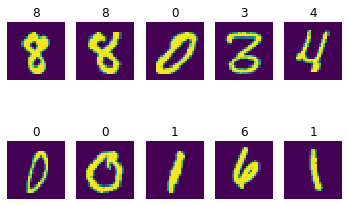

None


In [4]:
var i = 1
for features in mnist.take(10) {
    let image = features["image"], label = features["label"]
    plt.subplot(2, 5, i)
    i += 1
    plt.axis("off")
    plt.imshow(np.squeeze(image))
    plt.title(Int(label))
}
plt.show()

Create training batches and convert to `Tensor` using `numpy`:

In [5]:
let ds_train = mnist.shuffle(1000).batch(128).prefetch(10)
for features in ds_train.take(3) {
    let image = features["image"], label = features["label"]
    let np_image = tfds.as_numpy(image), np_label = tfds.as_numpy(label)
    let tensor_image = Tensor<UInt8>(numpy: np_image)!, tensor_label = Tensor<Int64>(numpy: np_label)!
    print(tensor_image.shape, tensor_label.shape)
}

[128, 28, 28, 1] [128]
[128, 28, 28, 1] [128]
[128, 28, 28, 1] [128]


Convert the entire dataset split to `Tensor`:

In [6]:
let np_train = tfds.as_numpy(tfds.load("mnist", split: "train", batch_size: -1))
let images = Tensor<UInt8>(numpy: np_train["image"])!, labels = Tensor<Int64>(numpy: np_train["label"])!
print(images.shape, labels.shape)

[60000, 28, 28, 1] [60000]


## DatasetBuilder

In [7]:
let mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()
let ds = mnist_builder.as_dataset(split: "train")
print(mnist_builder.info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

